In [5]:
ChatGPT was used to help code

import numpy as np
import matplotlib.pyplot as plt
import pywt
import openpyxl
from scipy.signal import find_peaks

In [6]:
# GENERATE TRAIN AND TEST DATA
def split_columns(file_path, first_percentage):
    wb = openpyxl.load_workbook(file_path, data_only=True)
    sheet = wb.active

    num_columns = sheet.max_column
    first_columns_count = int(num_columns * first_percentage)
    last_columns_count = num_columns - first_columns_count

    first_columns = []
    last_columns = []

    for row in sheet.iter_rows(values_only=True):
        first_columns.append(row[:first_columns_count])
        last_columns.append(row[first_columns_count:])

    return first_columns, last_columns


excel_file_path = "dataset_normal_person01.xlsx"
first_percentage = 0.8

first_columns, last_columns = split_columns(excel_file_path, first_percentage)

train_data = first_columns
test_data = last_columns


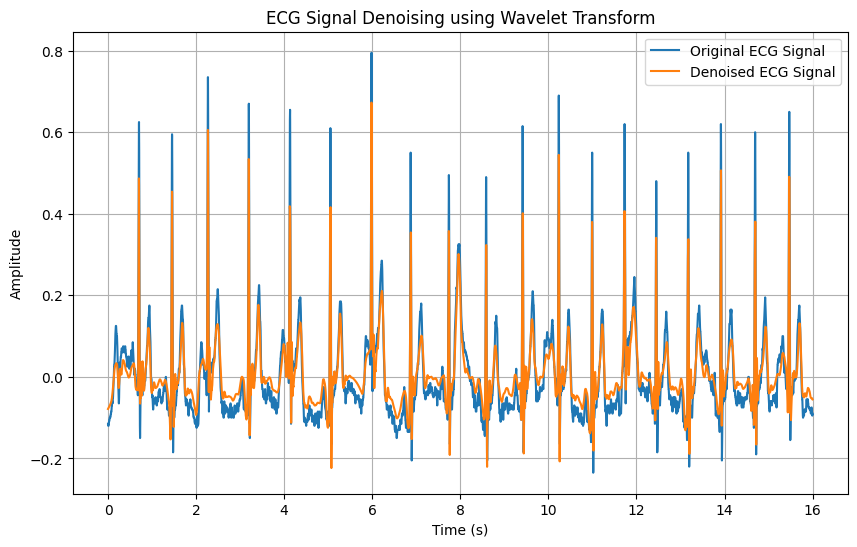

In [7]:
#### DENOISE THE ECG WITH WAVELET DECOMPOSITION
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 8000) / fs  # Time vector based on signal length
ecg_signal = np.array(train_data).reshape(-1)  # Replace with your actual ECG data

# Choose wavelet and decomposition level
wavelet_name = 'db4'  # Daubechies 4
level = 5

# Perform wavelet decomposition
coeffs = pywt.wavedec(ecg_signal, wavelet_name, level=level)

# Apply thresholding to denoise the wavelet coefficients
threshold = 0.2  # Adjust this threshold value as needed
denoised_coeffs = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs]

# Reconstruct the denoised ECG signal using inverse wavelet transform
denoised_signal = pywt.waverec(denoised_coeffs, wavelet_name)

# Plot the original and denoised ECG signals
plt.figure(figsize=(10, 6))
plt.plot(t, ecg_signal, label='Original ECG Signal')
plt.plot(t, denoised_signal, label='Denoised ECG Signal')
plt.title('ECG Signal Denoising using Wavelet Transform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


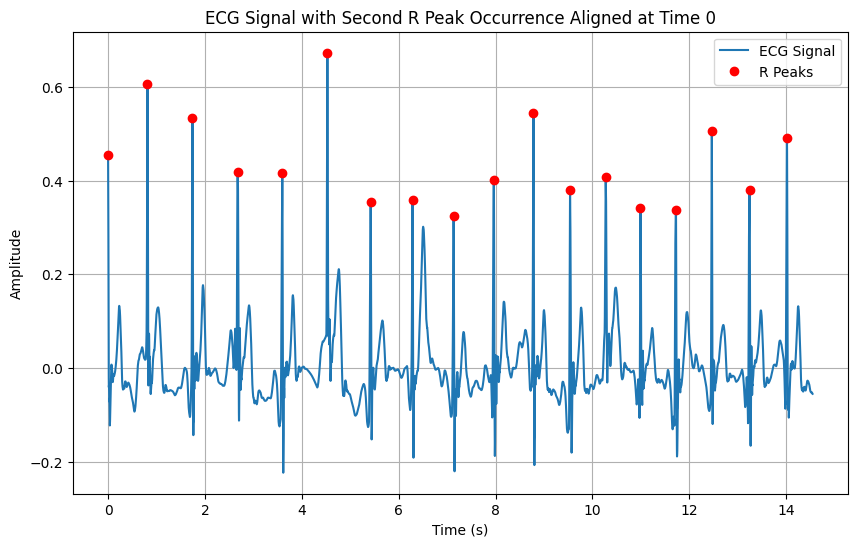

In [8]:
#### DETERMINE R-PEAKS AND ALSO ALIGN R-PEAK TO TIME ZERO
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 8000) / fs  # Time vector based on signal length

ecg_signal = denoised_signal

#### Find R-Peak and Align R-Peak to zeros
# Find the relatively highest points (R-peaks) in the ECG signal
r_peak_indices, _ = find_peaks(ecg_signal, height=0, distance=300)

# Sort the R-peak indices in ascending order
r_peak_indices_sorted = sorted(r_peak_indices)

# Remove the first R-peak index
r_peak_indices_sorted = r_peak_indices_sorted[1:]

# Find the index corresponding to the second R-peak occurrence
second_r_peak_index = r_peak_indices_sorted[0]  # Now this is the first element

# Set the second R-peak occurrence at time 0
time_shift = -t[second_r_peak_index]
t_shifted = t + time_shift

# Find the index corresponding to time 0
zero_index = np.argmax(t_shifted >= 0)

# Plot the ECG signal with the second R-peak occurrence aligned at time 0
plt.figure(figsize=(10, 6))
plt.plot(t_shifted[zero_index:], ecg_signal[zero_index:], label='ECG Signal')
plt.plot(t_shifted[r_peak_indices_sorted], ecg_signal[r_peak_indices_sorted], 'ro', label='R Peaks')
plt.title('ECG Signal with Second R Peak Occurrence Aligned at Time 0')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()



In [39]:
# Calculate the mean and standard deviation
mean_value = np.mean(ecg_signal)
std_deviation = np.std(ecg_signal)

print("Mean:", mean_value)
print("Standard Deviation:", std_deviation)


# Find R-peaks using scipy's find_peaks
peaks, _ = find_peaks(ecg_signal, height=0, distance=300)

# Calculate the number of samples between consecutive R-peaks
samples_between_rpeaks = np.diff(peaks)
average_samples_between_rpeaks = np.mean(samples_between_rpeaks)
print("Averge between R-peaks: ", average_samples_between_rpeaks)


Mean: 0.0029174999999999956
Standard Deviation: 0.11039588168835827
Averge between R-peaks:  422.0


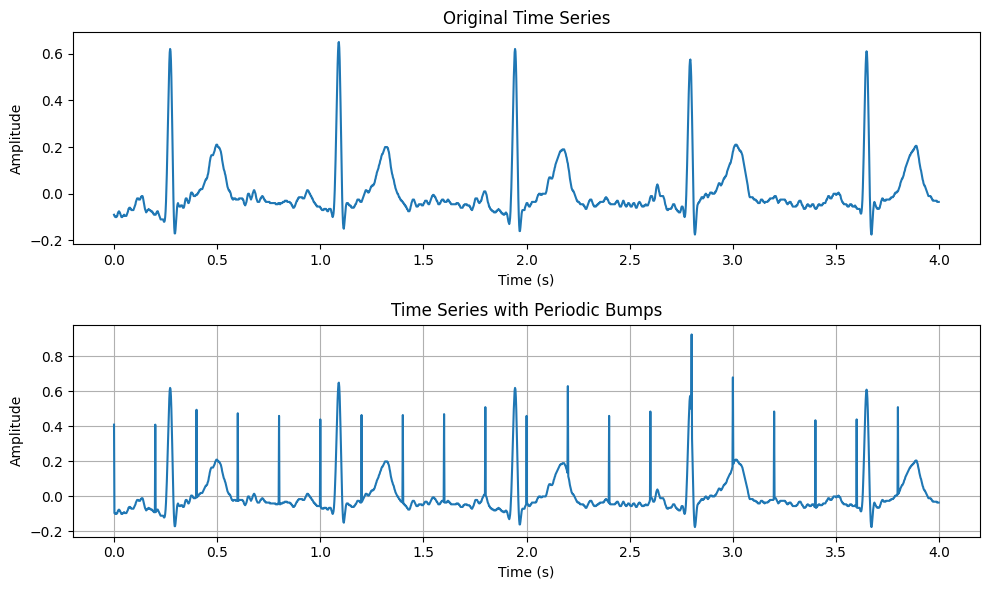

Number of anomalies is:  20


In [36]:
### Add anomaly
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 2000) / fs  # Time vector based on signal length
ecg_signal = np.array(test_data).reshape(-1)  # Replace with your actual ECG data
amplitude = mean_value + 3 * std_deviation

# Create a sinusoidal time series
original_time_series = ecg_signal

# Define parameters for the periodic bump
bump_period = 100*0.002  # Period of the bump (in seconds)
bump_duration = 0.002  # Duration of each bump (in seconds)
bump_amplitude = 0.5  # Amplitude of the bump

# Convert bump period from seconds to samples
bump_period_samples = int(bump_period * fs)

# Create a bump pattern
bump_pattern = np.zeros_like(t)
bump_indices = np.arange(0, len(t), bump_period_samples)
for idx in bump_indices:
    bump_pattern[idx:idx+int(bump_duration * fs)] = bump_amplitude

# Add the bump pattern to the original time series
time_series_with_bumps = original_time_series + bump_pattern

# Plot the original time series
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, original_time_series)
plt.title('Original Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the time series with periodic bumps
plt.subplot(2, 1, 2)
plt.plot(t, time_series_with_bumps)
plt.title('Time Series with Periodic Bumps')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


# Count the number of values above the threshold
distance = np.abs(original_time_series - time_series_with_bumps)
threshold = amplitude
count_above_threshold = np.sum(distance >= threshold)
print("Number of anomalies is: ", count_above_threshold)